## H

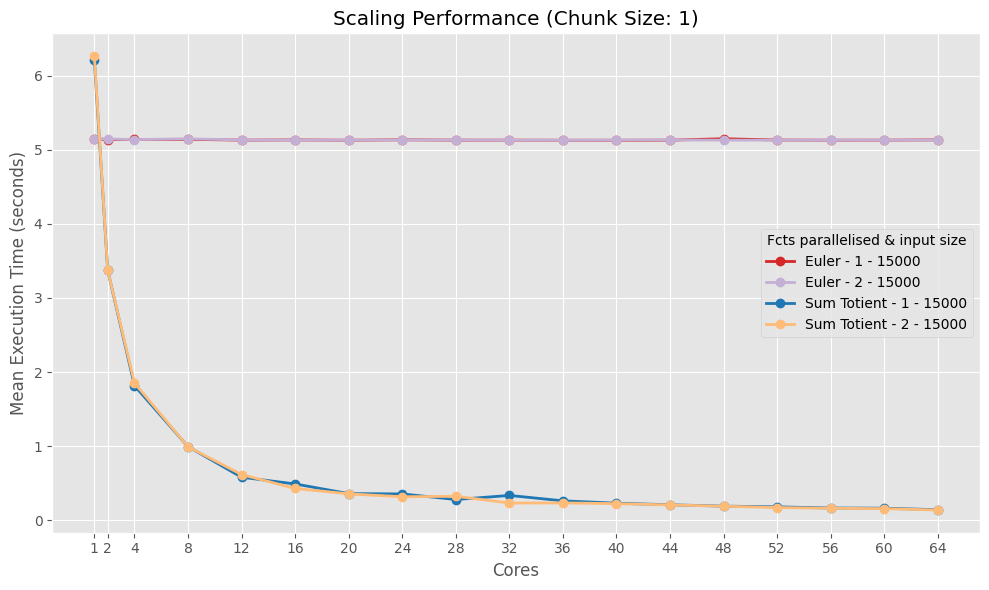

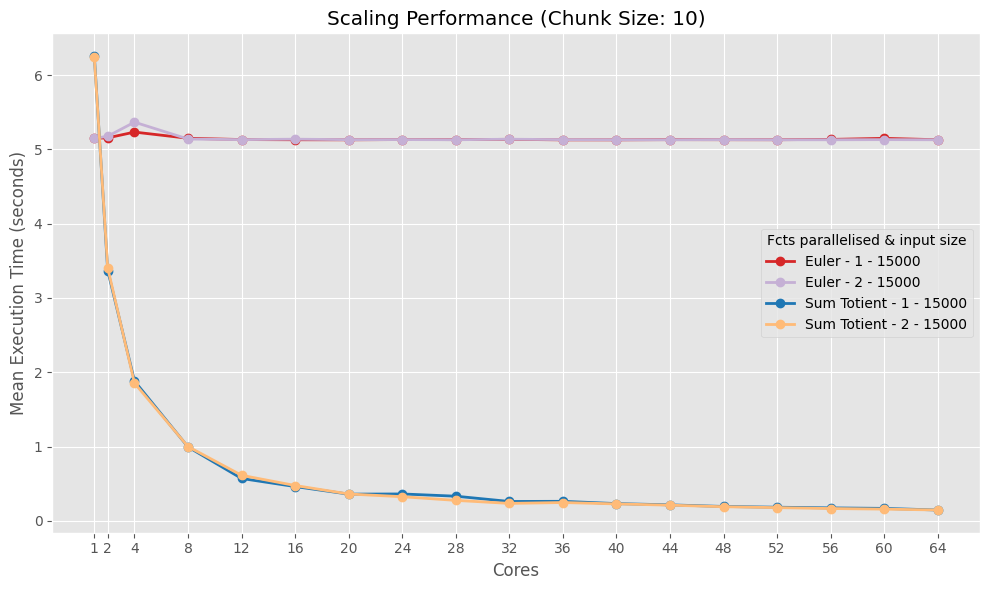

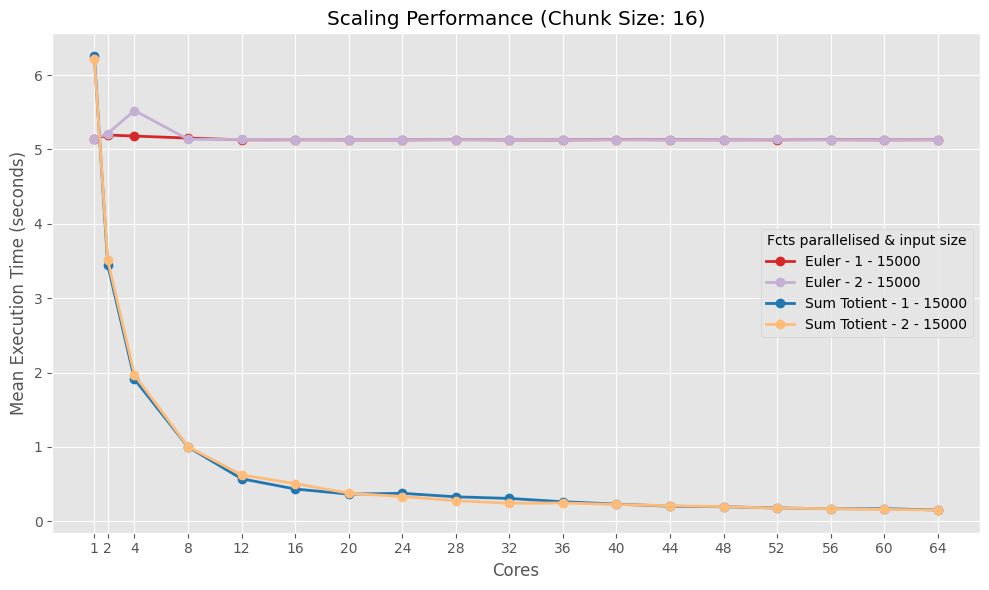

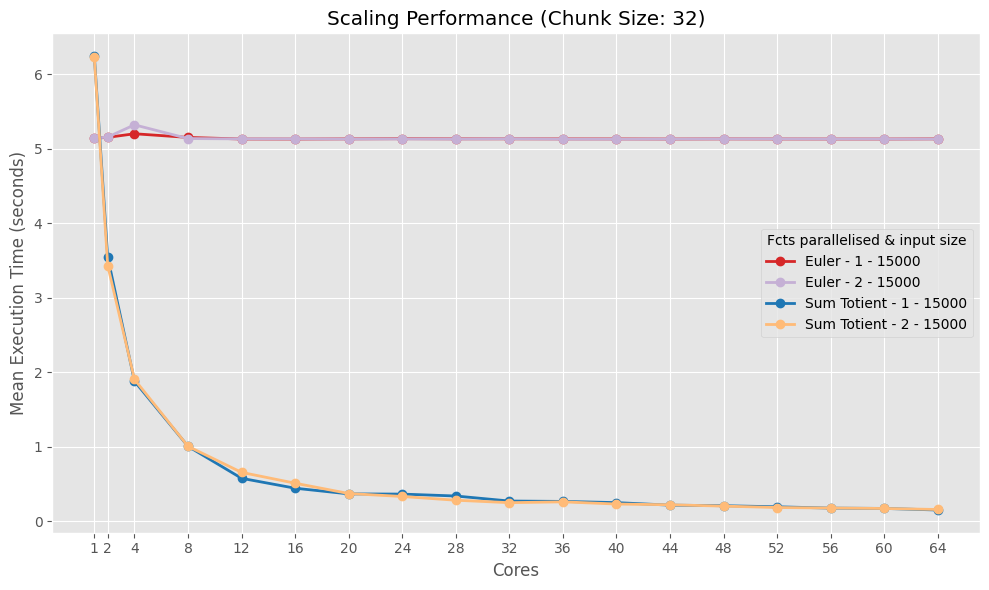

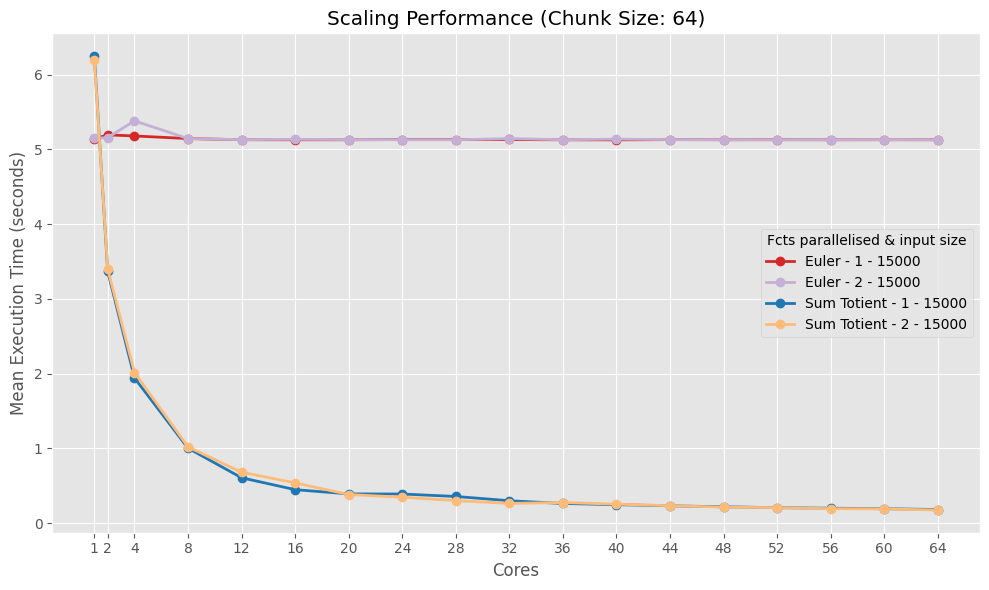

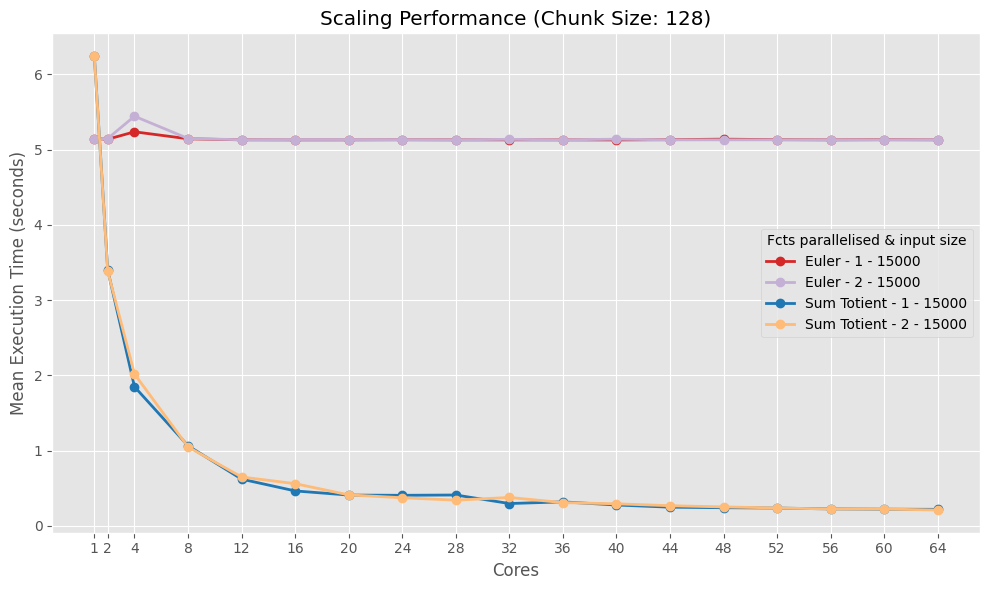

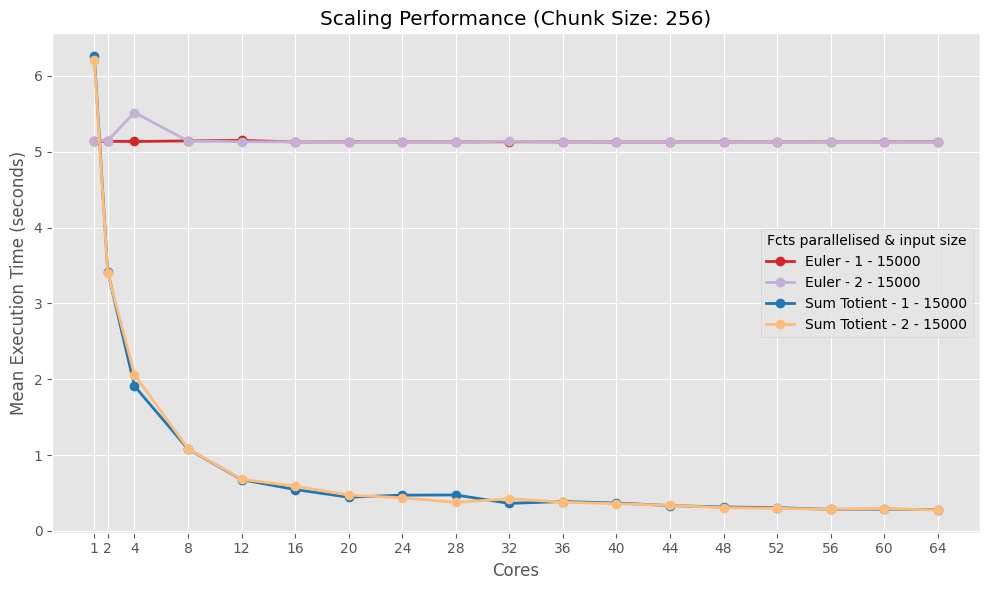

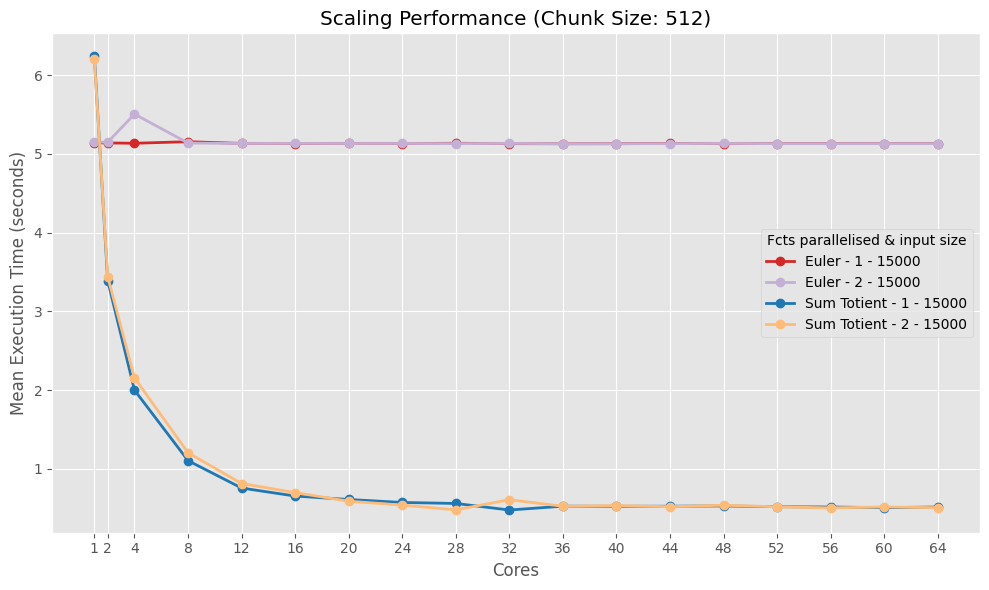

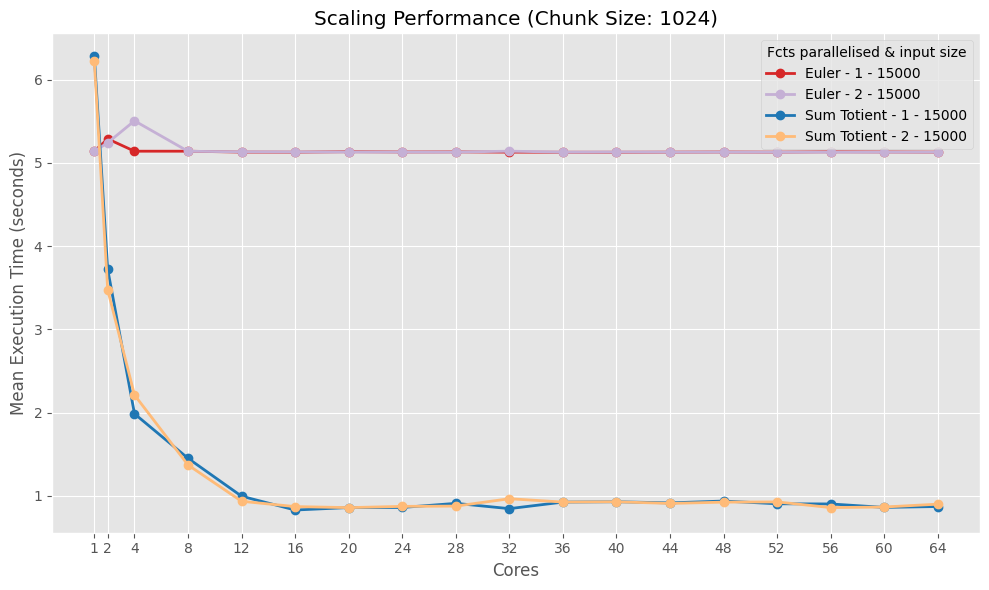

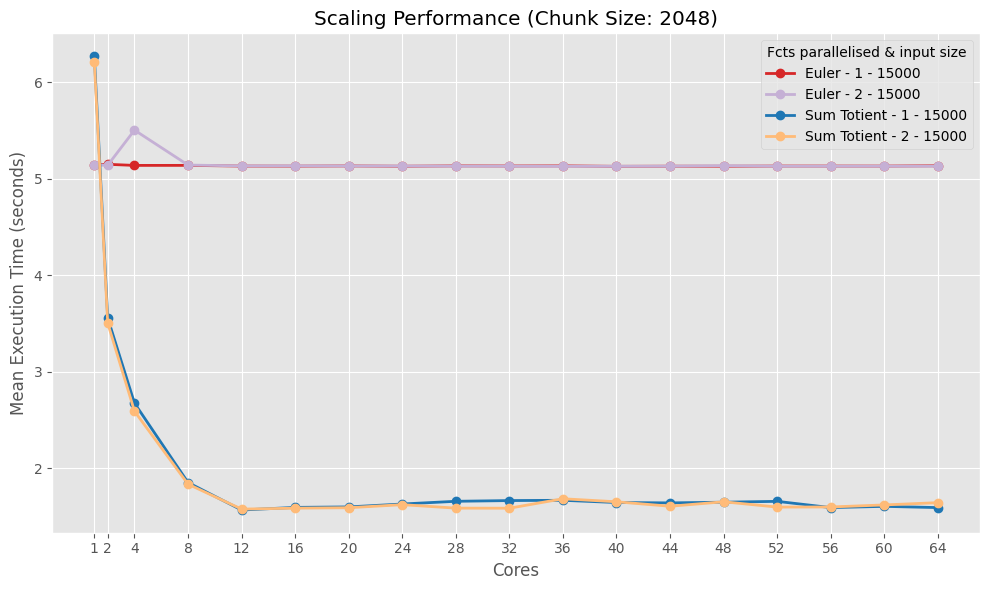

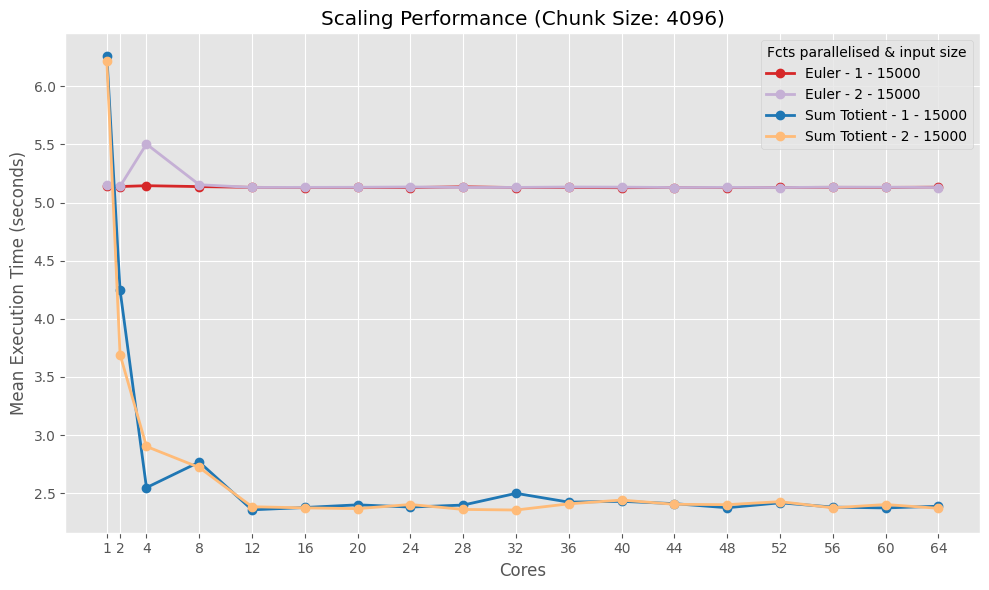

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import io

# 1. LOAD DATA
# I am creating the CSV from the string for demonstration.
# In real usage, you would use: df = pd.read_csv('your_file.csv') 
# Note: I added a few dummy rows above so you can see a line graph. 
# Replace csv_data with your actual file loading.

csv_data = open("runtime.csv")

df = pd.read_csv(io.StringIO(csv_data.read()), skiprows = [1, 2, 3])

# 2. PROCESS DATA
# Calculate mean time across the three runs

# chunk_sizes = df['chunk_size'].unique()
# calculation_type = ['s1', 's2', 'e1', 'e2']

# for chunk in chunk_sizes:
#     mask = df['chunk_size'] == chunk

#     for ct in calculation_type:
#         cols = [f'run{i}{ct}' for i in range(1, 6)]
#         df.loc[mask, f'mean_time_{ct}_{chunk}'] = df.loc[mask, cols].mean(axis=1)

# print(df['mean_time_s1_1'])
# print(df['mean_time_s1_64'])

run_cols = [c for c in df.columns if c.startswith('run')]

long = df.melt(
    id_vars=['input', 'cores', 'chunk_size'],
    value_vars=run_cols,
    var_name='run_stage',
    value_name='time'
)

long['stage'] = long['run_stage'].str.extract(r'run\d+(s\d|e\d)')

result = (
    long
    .groupby(['input', 'cores', 'chunk_size', 'stage'], as_index=False)
    .agg(mean_time=('time', 'mean'))
)


# Set style
plt.style.use('ggplot')

# 3. GENERATE A GRAPH FOR EACH CHUNK SIZE
chunk_sizes = sorted(df['chunk_size'].unique())


stages = ['s1', 's2', 'e1', 'e2']
input_sizes = [15000, 30000, 100000]

# Create all combinations
keys = [(s, i) for s in stages for i in input_sizes]

cmap = plt.get_cmap('tab20')  # 20 distinct colors
color_map = {
    key: cmap(idx)
    for idx, key in enumerate(keys)
}

for cs in chunk_sizes:
    plt.figure(figsize=(10, 6))
    
    subset_cs = result[result['chunk_size'] == cs]
    unique_inputs = sorted(subset_cs['input'].unique())
    
    for input_size in unique_inputs:
        if input_size >= 20000 or input_size == 100000:
            continue
        # Filter for the specific input size
        data_to_plot = subset_cs[subset_cs['input'] == input_size].sort_values(by='cores')
        
        labels = {
            's1': 'Sum Totient - 1',
            's2': 'Sum Totient - 2',
            'e1': 'Euler - 1',
            'e2': 'Euler - 2',
        }

        for stage, subset in data_to_plot.groupby('stage'):
            # if stage.__contains__('2'):
            #     continue
            plt.plot(
                subset['cores'],
                subset['mean_time'],
                marker='o',
                linewidth=2,
                color=color_map[(stage, input_size)],
                label=f"{labels[stage]} - {input_size}"
            )
    
    # Updated Labels
    plt.xlabel('Cores')
    plt.ylabel('Mean Execution Time (seconds)')
    plt.title(f'Scaling Performance (Chunk Size: {cs})')
    
    # Optional: Force X-axis to show integer core counts
    plt.xticks(sorted(df['cores'].unique()))
    
    plt.legend(title="Fcts parallelised & input size")
    plt.grid(True)
    plt.tight_layout()
    
    # Show/Save
    plt.show()



#*

In [ ]:
df.columns